# 1 min data

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from prophet import Prophet

In [3]:

root_dir = './data/one_min_data/'

def read_stock_data(stock_ticker):
    stock_dir = os.path.join(root_dir, stock_ticker)
    stock_files = os.listdir(stock_dir)
    df = pd.DataFrame()
    for stock_file in stock_files:
        stock_full_path = os.path.join(stock_dir, stock_file)
        df_csv = pd.read_csv(stock_full_path, index_col=0)
        df = pd.concat([df, df_csv])

    df['stock_id'] = stock_ticker
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by="timestamp", ascending=True)
    df = df.reset_index(drop=True)
    df = df.set_index('timestamp')
    return df


In [28]:
df_stock = read_stock_data('AAPL')
df_stock

,open,high,low,close,volume,stock_id
timestamp,,,,,,
2000-01-03 09:30:00,0.796,0.798,0.795,0.797,3662400,AAPL
2000-01-03 09:31:00,0.797,0.801,0.795,0.796,1456000,AAPL
2000-01-03 09:32:00,0.796,0.800,0.795,0.798,4020800,AAPL
2000-01-03 09:33:00,0.797,0.800,0.793,0.797,4065600,AAPL
2000-01-03 09:34:00,0.797,0.799,0.792,0.793,8870400,AAPL
...,...,...,...,...,...,...
2023-07-20 19:55:00,192.700,192.720,192.660,192.690,1473,AAPL
2023-07-20 19:56:00,192.670,192.720,192.650,192.650,1011,AAPL
2023-07-20 19:57:00,192.650,192.730,192.640,192.690,1180,AAPL


In [29]:
df_stock.to_csv("AAPL_one_min.csv", index=False)

In [5]:
df_stock_close = df_stock['close'].to_frame()
df_stock_close

,close
timestamp,
2000-01-03 09:30:00,0.797
2000-01-03 09:31:00,0.796
2000-01-03 09:32:00,0.798
2000-01-03 09:33:00,0.797
2000-01-03 09:34:00,0.793
...,...
2023-07-20 19:55:00,192.690
2023-07-20 19:56:00,192.650
2023-07-20 19:57:00,192.690


In [6]:
df_stock_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3584433 entries, 2000-01-03 09:30:00 to 2023-07-20 19:59:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   close   float64
dtypes: float64(1)
memory usage: 54.7 MB


In [7]:
# realized_volatility
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def log_return(list_stock_prices):
    # pandas dataframe diff() calculates the difference of a DataFrame element compared with another element in the DataFrame (default is element in previous row)
    return np.log(list_stock_prices).diff() 

def calculate_log_return(df_log_return_orig, columns):
    df_log_return = df_log_return_orig.copy()
    for column in columns:
        df_log_return[column + '_log'] = log_return(df_log_return[column])

    return df_log_return

def calculate_realized_volatility(df_rv_orig, columns, time_group):
    df_rv = df_rv_orig.copy()
    for column in columns:
        df_rv[column + '_rv'] = df_rv[column].resample(time_group).apply(realized_volatility)

    df_rv = df_rv.resample(time_group).sum(numeric_only=True)
        
    return df_rv

def make_realized_volatility(df_rv, columns, time_group):
    df_rv = calculate_log_return(df_rv, columns)
    log_columns = [c + '_log' for c in columns]
    df_rv = calculate_realized_volatility(df_rv, log_columns, time_group)
    return df_rv

In [8]:
one_date = datetime.date(2000,1,3)
df_stock_mini_one_day = df_stock_close[df_stock_close.index.date == one_date]
df_stock_mini_one_day

,close
timestamp,
2000-01-03 09:30:00,0.797
2000-01-03 09:31:00,0.796
2000-01-03 09:32:00,0.798
2000-01-03 09:33:00,0.797
2000-01-03 09:34:00,0.793
...,...
2000-01-03 15:57:00,0.851
2000-01-03 15:58:00,0.848
2000-01-03 15:59:00,0.850


In [9]:
rv_one_day = make_realized_volatility(df_stock_mini_one_day, ['close'], "5min")
rv_one_day

,close,close_log,close_log_rv
timestamp,,,
2000-01-03 09:30:00,3.981,-0.005031,0.005896
2000-01-03 09:35:00,3.949,-0.008866,0.004909
2000-01-03 09:40:00,3.922,0.001271,0.005556
2000-01-03 09:45:00,3.970,0.008855,0.010347
2000-01-03 09:50:00,3.962,-0.003785,0.002822
...,...,...,...
2000-01-03 15:40:00,4.195,-0.001194,0.005461
2000-01-03 15:45:00,4.193,-0.001195,0.004302
2000-01-03 15:50:00,4.196,0.008338,0.004609


In [10]:
# rv_all = make_realized_volatility(df_stock_close, ['close'], "5min")
rv_all = rv_one_day.copy()

In [11]:
# ['close','open','high','low']
df_stock_mini = calculate_log_return(df_stock_mini_one_day, ['close'])
df_stock_mini

,close,close_log
timestamp,,
2000-01-03 09:30:00,0.797,NaN
2000-01-03 09:31:00,0.796,-0.001255
2000-01-03 09:32:00,0.798,0.002509
2000-01-03 09:33:00,0.797,-0.001254
2000-01-03 09:34:00,0.793,-0.005031
...,...,...
2000-01-03 15:57:00,0.851,-0.001174
2000-01-03 15:58:00,0.848,-0.003531
2000-01-03 15:59:00,0.850,0.002356


In [12]:
# ['close_log_return', 'open_log_return','high_log_return','low_log_return']
df_stock_mini = calculate_realized_volatility(df_stock_mini, ['close_log'], "5min")
df_stock_mini

,close,close_log,close_log_rv
timestamp,,,
2000-01-03 09:30:00,3.981,-0.005031,0.005896
2000-01-03 09:35:00,3.949,-0.008866,0.004909
2000-01-03 09:40:00,3.922,0.001271,0.005556
2000-01-03 09:45:00,3.970,0.008855,0.010347
2000-01-03 09:50:00,3.962,-0.003785,0.002822
...,...,...,...
2000-01-03 15:40:00,4.195,-0.001194,0.005461
2000-01-03 15:45:00,4.193,-0.001195,0.004302
2000-01-03 15:50:00,4.196,0.008338,0.004609


In [13]:
# plt.plot(df_stock_mini['timestamp'], df_stock_mini['close'])
def draw_line_plot(x, y, x_label, y_label, title):
    if x is not None:
        plt.plot(x,y)
    else:
        plt.plot(y)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show();

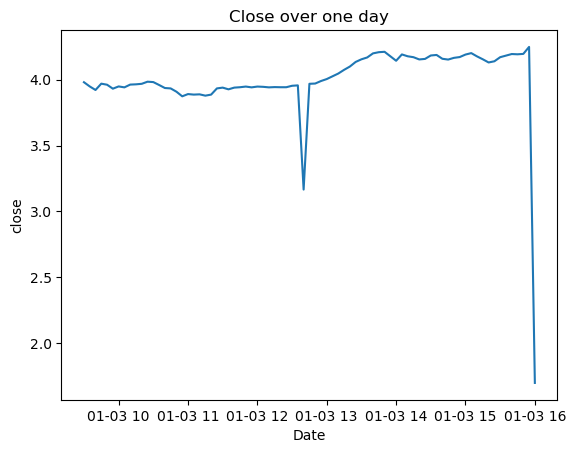

In [14]:
draw_line_plot(rv_one_day.index.values, rv_one_day['close'].values, 'Date', 'close', 'Close over one day')

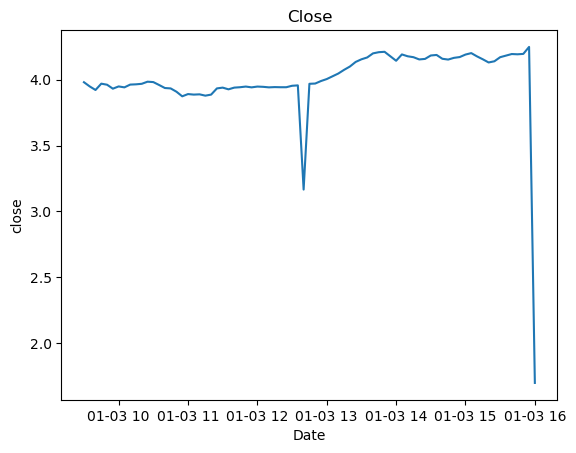

In [15]:
draw_line_plot(rv_all.index.values, rv_all['close'].values, 'Date', 'close', 'Close')

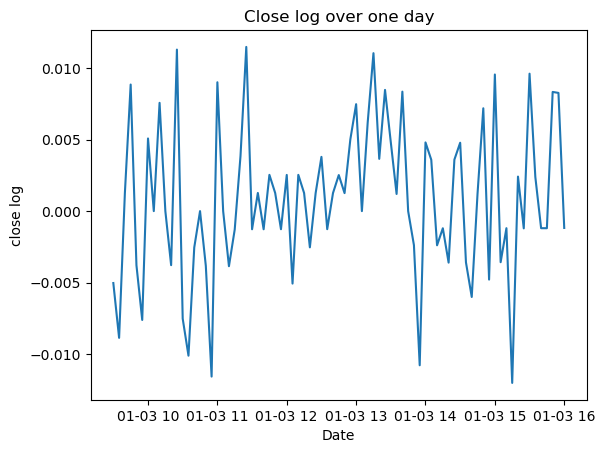

In [16]:
draw_line_plot(rv_one_day.index.values, rv_one_day['close_log'].values, 'Date', 'close log', 'Close log over one day')

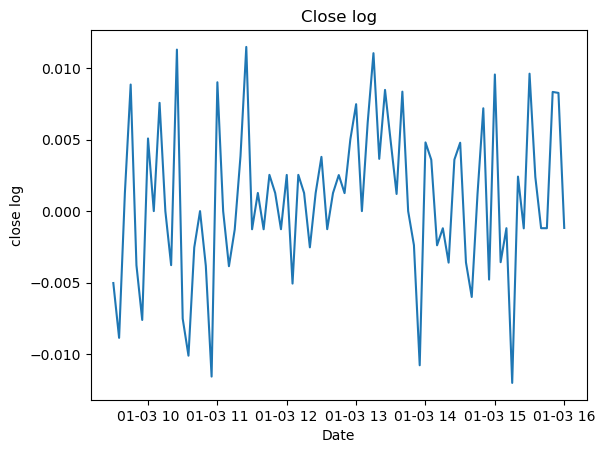

In [17]:
draw_line_plot(rv_all.index.values, rv_all['close_log'].values, 'Date', 'close log', 'Close log')

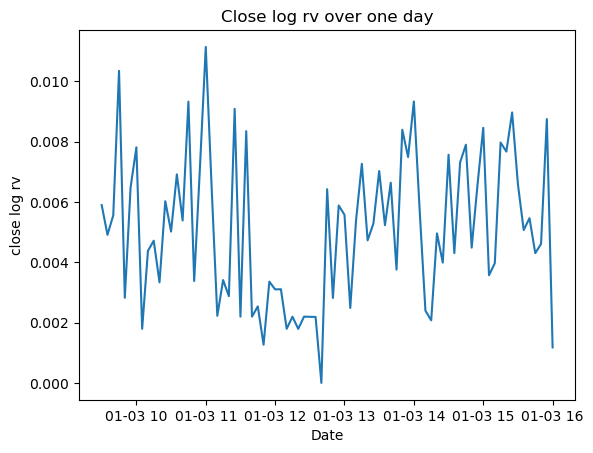

In [18]:
draw_line_plot(rv_one_day.index.values, rv_one_day['close_log_rv'].values, 'Date', 'close log rv', 'Close log rv over one day')

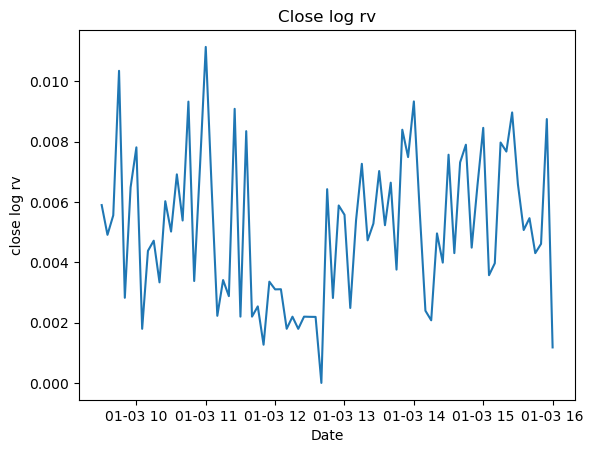

In [19]:
draw_line_plot(rv_all.index.values, rv_all['close_log_rv'].values, 'Date', 'close log rv', 'Close log rv')

In [20]:
rv_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2000-01-03 09:30:00 to 2000-01-03 16:00:00
Freq: 5T
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   close         79 non-null     float64
 1   close_log     79 non-null     float64
 2   close_log_rv  79 non-null     float64
dtypes: float64(3)
memory usage: 2.5 KB


In [21]:
rv_one_day

,close,close_log,close_log_rv
timestamp,,,
2000-01-03 09:30:00,3.981,-0.005031,0.005896
2000-01-03 09:35:00,3.949,-0.008866,0.004909
2000-01-03 09:40:00,3.922,0.001271,0.005556
2000-01-03 09:45:00,3.970,0.008855,0.010347
2000-01-03 09:50:00,3.962,-0.003785,0.002822
...,...,...,...
2000-01-03 15:40:00,4.195,-0.001194,0.005461
2000-01-03 15:45:00,4.193,-0.001195,0.004302
2000-01-03 15:50:00,4.196,0.008338,0.004609


In [22]:
df_prophet = pd.DataFrame()
df_prophet['y'] = rv_one_day['close_log_rv']
df_prophet['ds'] = rv_one_day.index
df_prophet = df_prophet.reset_index(drop=True)

In [27]:
df_prophet.to_csv("one_day.csv", index=False)

In [24]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       79 non-null     float64       
 1   ds      79 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


In [25]:
prophet = Prophet()
prophet.fit(df_prophet)

00:42:23 - cmdstanpy - INFO - Chain [1] start processing
00:42:23 - cmdstanpy - INFO - Chain [1] done processing
00:42:23 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6


RuntimeError: Error during optimization! Command '/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin random seed=92890 data file=/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/tmpw2w16jn0/cwijrspt.json init=/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/tmpw2w16jn0/kqq75u9l.json output file=/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/tmpw2w16jn0/prophet_modelhrlbgzli/prophet_model-20230722004223.csv method=optimize algorithm=newton iter=10000' failed: console log output:

dyld[79046]: Library not loaded: @rpath/libtbb.dylib
  Referenced from: <EFE7E902-29DD-351C-A3AA-6FB0B49D55F4> /Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin
  Reason: tried: '/private/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/pip-install-7k0o147_/prophet_3e4906e1fdae4895a22da10dae1bd0f5/build/lib.macosx-11.0-arm64-cpython-310/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/pip-install-7k0o147_/prophet_3e4906e1fdae4895a22da10dae1bd0f5/build/lib.macosx-11.0-arm64-cpython-310/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/pip-install-7k0o147_/prophet_3e4906e1fdae4895a22da10dae1bd0f5/build/lib.macosx-11.0-arm64-cpython-310/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/pip-install-7k0o147_/prophet_3e4906e1fdae4895a22da10dae1bd0f5/build/lib.macosx-11.0-arm64-cpython-310/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/pip-install-7k0o147_/prophet_3e4906e1fdae4895a22da10dae1bd0f5/build/lib.macosx-11.0-arm64-cpython-310/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/pip-install-7k0o147_/prophet_3e4906e1fdae4895a22da10dae1bd0f5/build/lib.macosx-11.0-arm64-cpython-310/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/pip-install-7k0o147_/prophet_3e4906e1fdae4895a22da10dae1bd0f5/build/lib.macosx-11.0-arm64-cpython-310/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/pip-install-7k0o147_/prophet_3e4906e1fdae4895a22da10dae1bd0f5/build/lib.macosx-11.0-arm64-cpython-310/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/usr/local/lib/libtbb.dylib' (no such file), '/usr/lib/libtbb.dylib' (no such file, not in dyld cache)
